#### Importing the relevant libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# We can override the default matplotlib styles with those of Seaborn
sns.set()## Importing the relevant libraries

In [3]:
# Load the data from a .csv
raw_credits_data = pd.read_csv(
    os.path.join(os.path.pardir,'data','processed','credits.csv'), low_memory=False)
raw_movies_metadata = pd.read_csv(
    os.path.join(os.path.pardir,'data','processed','movies_metadata.csv'), low_memory=False)
raw_keywords_data = pd.read_csv(
    os.path.join(os.path.pardir,'data','processed','keywords.csv'), low_memory=False)

In [30]:
credits_df = raw_credits_data.copy()
metadata_df = raw_movies_metadata.copy()
keywords_df = raw_keywords_data.copy()

># 1. Simple Recommenders
 - simple recommenders are basic systems that recommends the top items based on a certain metric or score.

>In this section, we will build a simplified clone of IMDB Top 250 Movies using metadata collected from IMDB.

> The following are the steps involved:
>- Decide on the metric or score to rate movies on.
>- Calculate the score for every movie.
> - Sort the movies based on the score and output the top results.

In [88]:
metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


>One of the most basic metrics we can think of is the rating. However, using this metric has a few caveats. For one, it does not take into consideration the popularity of a movie. Therefore, a movie with a rating of 9 from 10 voters will be considered 'better' than a movie with a rating of 8.9 from 10,000 voters.
***
>On a related note, this metric will also tend to favor movies with smaller number of voters with skewed and/or extremely high ratings. As the number of voters increase, the rating of a movie regularizes and approaches towards a value that is reflective of the movie's quality. It is more difficult to discern the quality of a movie with extremely few voters.
***
>Taking these shortcomings into consideration, it is necessary that we come up with a weighted rating that takes into account the average rating and the number of votes it has garnered. Such a system will make sure that a movie with a 9 rating from 100,000 voters gets a (far) higher score than a YouTube Web Series with the same rating but a few hundred voters.
***
>Since we are trying to build a clone of IMDB's Top 250, we will use its weighted rating formula as our metric/score. Mathematically, it is represented as follows:
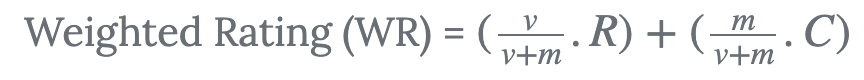
where,
>>v is the number of votes for the movie;  
>>m is the minimum votes required to be listed in the chart;  
>>R is the average rating of the movie; And  
>>C is the mean vote across the whole report  
***
>We already have the values to `v (vote_count)` and `R (vote_average)` for each movie in the dataset. It is also possible to directly calculate C from this data.
***
>What we need to determine is an appropriate value for m, the minimum votes required to be listed in the chart. There is no right value for m. We can view it as a preliminary negative filter that ignores movies which have less than a certain number of votes. The selectivity of our filter is up to our discretion.
***
>In this case, we will use the 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list. (On the other hand, if we had chosen the 75th percentile, we would have considered the top 25% of the movies in terms of the number of votes garnered. As the percentile decreases, the number of movies considered increases. Feel free to play with this value and observe the changes in our final chart).
***
>As a first step, let's calculate the value of C, the mean rating across all movies:

In [32]:
# Calculate C
C = metadata_df['vote_average'].mean()

In [33]:
C
# The average rating of a movie on IMDB is around 5.6, on a scale of 10.

5.618207215134185

>Next, let's calculate the number of votes, m, received by a movie in the 90th percentile. The pandas library makes this task extremely trivial using the .quantile() method of a pandas Series:

In [34]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata_df['vote_count'].quantile(0.90)
m

160.0

> Next, we can filter the movies that qualify for the chart, based on their vote counts:

In [35]:
# Filter out all qualified movies into a new DataFrame
qualified_movies = metadata_df.copy().loc[metadata_df['vote_count'] >= m]
qualified_movies.shape

(4555, 24)

In [36]:
qualified_movies.sort_values('vote_average', ascending=False).head(10)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
10309,False,NaN,13200000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,19404,tt0112870,hi,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",...,1995-10-20,1.000000e+08,190.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,Come... Fall In Love,Dilwale Dulhania Le Jayenge,False,9.1,661.0
39085,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,192040,tt0795176,en,Planet Earth,A documentary miniseries described by its make...,...,2006-12-10,0.000000e+00,550.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,planet earth as you've never seen it before,Planet Earth,False,8.8,176.0
314,False,NaN,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,278,tt0111161,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,...,1994-09-23,2.834147e+07,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,False,8.5,8358.0
40251,False,NaN,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 16, ...",https://www.funimationfilms.com/movie/yourname/,372058,tt5311514,ja,君の名は。,High schoolers Mitsuha and Taki are complete s...,...,2016-08-26,3.552983e+08,106.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Your Name.,False,8.5,1030.0
834,False,"{'id': 230, 'name': 'The Godfather Collection'...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.thegodfather.com/,238,tt0068646,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",...,1972-03-14,2.450664e+08,175.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An offer you can't refuse.,The Godfather,False,8.5,6024.0
12481,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,2008-07-16,1.004558e+09,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,The Dark Knight,False,8.3,12269.0
292,False,NaN,8000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",NaN,680,tt0110912,en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",...,1994-09-10,2.139288e+08,154.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,False,8.3,8670.0
522,False,NaN,22000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",http://www.schindlerslist.com/,424,tt0108052,en,Schindler's List,The true story of how businessman Oskar Schind...,...,1993-11-29,3.213656e+08,195.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,"Whoever saves one life, saves the world entire.",Schindler's List,False,8.3,4436.0
5481,False,NaN,15000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 12, 'na...",http://movies.disney.com/spirited-away,129,tt0245429,ja,千と千尋の神隠し,A ten year old girl who wanders away from her ...,...,2001-07-20,2.749251e+08,125.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,The tunnel led Chihiro to a mysterious town...,Spirited Away,False,8.3,3968.0
23673,False,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,244786,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",...,2014-10-10,1.309200e+07,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,False,8.3,4376.0


>We see that there are 4555 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [11]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [37]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)

In [38]:
qualified_movies

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,score
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,3.735540e+08,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,7.640253
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,2.627972e+08,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,6.820293
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,7.657891e+07,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,5.660700
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1.874368e+08,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,7.537201
8,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,6.435017e+07,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,5.556626
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,3.521940e+08,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,6.483983
10,False,NaN,62000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,9087,tt0112346,en,The American President,"Widowed U.S. president Andrew Shepherd, one of...",...,1.078795e+08,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Why can't the most powerful man in the world h...,The American President,False,6.5,199.0,6.107000
11,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,12110,tt0112896,en,Dracula: Dead and Loving It,When a lawyer shows up at the vampire's doorst...,...,0.000000e+00,88.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Dracula: Dead and Loving It,False,5.7,210.0,5.664630
12,False,"{'id': 117693, 'name': 'Balto Collection', 'po...",0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",NaN,21032,tt0112453,en,Balto,An outcast half-wolf risks his life to prevent...,...,1.134832e+07,78.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Part Dog. Part Wolf. All Hero.,Balto,False,7.1,423.0,6.693333
15,False,NaN,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,524,tt0112641,en,Casino,The life of the gambling paradise – Las Vegas ...,...,1.161124e+08,178.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No one stays at the top forever.,Casino,False,7.8,1343.0,7.567740


>Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 15 movies.

In [39]:
#Sort movies based on score calculated above
qualified_movies = qualified_movies.sort_values('score', ascending=False)

#Print the top 15 movies
qualified_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


Text(0, 0.5, 'Movie Title')

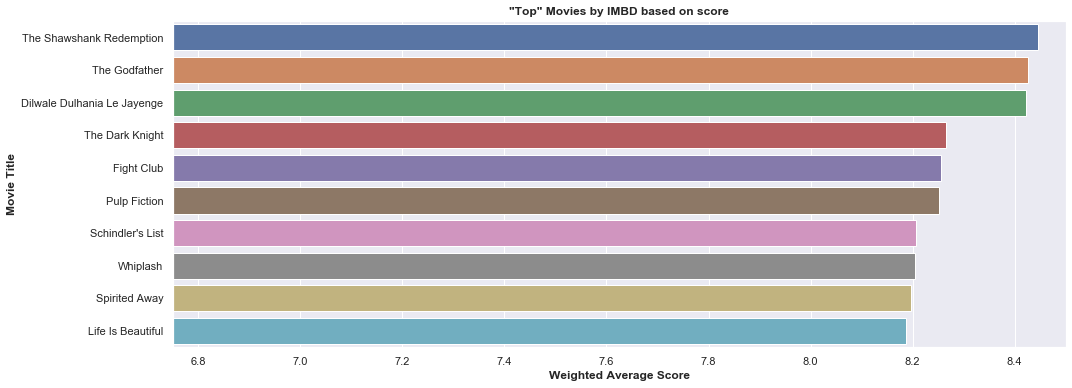

In [40]:
# To get a graph of the top 10 IMDB movies:

plt.figure(figsize=(16,6))
ax = sns.barplot(x=qualified_movies['score'].head(10), y=qualified_movies['title'].head(10),
                 data=qualified_movies, palette='deep')

plt.xlim(6.75, 8.5)
plt.title('"Top" Movies by IMBD based on score', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

# plt.savefig('best_movies.png')

>We see that the chart has a lot of movies in common with the IMDB Top 250 chart: for example, our top two movies, "Shawshank Redemption" and "The Godfather", are the same as IMDB.

# 2.0 Content-Based Recommender

>###### Plot Description Based Recommender
>In this section, we will try to build a system that recommends movies that are similar to a particular movie. More specifically, we will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score.
***
>The plot description is available to we as the `overview` feature in our `metadata_df` dataset

In [46]:
metadata_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '..."
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...","[{'id': 90, 'name': 'paris'}, {'id': 380, 'nam..."
7,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,"[{'cast_id': 2, 'character': 'Tom Sawyer', 'cr...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",[]
8,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,"[{'iso_639_1':

In [17]:
#Print plot overviews of the first 5 movies.
metadata_df['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

>In its current form, it is not possible to compute the similarity between any two overviews. To do this, we need to compute the word vectors of each overview or document, as it will be called from now on.
***
>We will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. This will give us a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each column represents a movie, as before.
***
>In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.
***
>Fortunately, scikit-learn gives we a built-in TfIdfVectorizer class that produces the TF-IDF matrix

In [41]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata_df['overview'] = metadata_df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata_df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(45466, 75827)

>We see that over 75,000 different words were used to describe the 45,000 movies in our dataset.
***
>With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. Again, there is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.
***
>We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate (especially when used in conjunction with TF-IDF scores). Mathematically, it is defined as follows:

 > Weighted Rating(WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$
***
>Since we have used the TF-IDF vectorizer, calculating the dot product will directly give we the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of **cosine_similarities()** since it is faster.

In [19]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

>We're going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title

In [42]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata_df.index, index=metadata_df['title']).drop_duplicates()

In [21]:
indices

title
Toy Story                               0
Jumanji                                 1
Grumpier Old Men                        2
Waiting to Exhale                       3
Father of the Bride Part II             4
Heat                                    5
Sabrina                                 6
Tom and Huck                            7
Sudden Death                            8
GoldenEye                               9
The American President                 10
Dracula: Dead and Loving It            11
Balto                                  12
Nixon                                  13
Cutthroat Island                       14
Casino                                 15
Sense and Sensibility                  16
Four Rooms                             17
Ace Ventura: When Nature Calls         18
Money Train                            19
Get Shorty                             20
Copycat                                21
Assassins                              22
Powder                      

>We are now in a good position to define our recommendation function. These are the following steps we'll follow:
***
>Get the index of the movie given its title.
>1. Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
>1. Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
>1. Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
>1. Return the titles corresponding to the indices of the top elements.

In [43]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return metadata_df['title'].iloc[movie_indices]

In [23]:
get_recommendations('The Dark Knight Rises')

12481                                      The Dark Knight
150                                         Batman Forever
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
585                                                 Batman
21194    Batman Unmasked: The Psychology of the Dark Kn...
9230                    Batman Beyond: Return of the Joker
18035                                     Batman: Year One
19792              Batman: The Dark Knight Returns, Part 1
3095                          Batman: Mask of the Phantasm
Name: title, dtype: object

In [24]:
get_recommendations('The Godfather')

1178               The Godfather: Part II
44030    The Godfather Trilogy: 1972-1990
1914              The Godfather: Part III
23126                          Blood Ties
11297                    Household Saints
34717                   Start Liquidation
10821                            Election
38030            A Mother Should Be Loved
17729                   Short Sharp Shock
26293                  Beck 28 - Familjen
Name: title, dtype: object

> We see that, while our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by our present system.

## Credits, Genres and Keywords Based Recommender

> We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.
***
> The keywords, cast and crew data is not available in the current dataset so the first step would be merge them into our main DataFrame.

In [44]:
# Convert IDs to int. Required for merging
keywords_df['id'] = keywords_df['id'].astype('int')
credits_df['id'] = credits_df['id'].astype('int')
# # Remove rows with bad IDs.
metadata_df = metadata_df.drop([19730, 29503, 35587])
metadata_df['id'] = metadata_df['id'].astype('int')

# Merge keywords and credits into our main metadata dataframe
metadata_df = metadata_df.merge(credits_df, on='id')
metadata_df = metadata_df.merge(keywords_df, on='id')

In [27]:
metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


> From our new features, cast, crew and keywords, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists. We need to convert them into a form that is usable for us.

In [56]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata_df[feature] = metadata_df[feature].fillna('').apply(literal_eval)
metadata_df

>Next, we write functions that will help us extract the required information from each feature. 

In [61]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [62]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [63]:
# Define new director, cast, genres and keywords features that are in a suitable form.
metadata_df['director'] = metadata_df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata_df[feature] = metadata_df[feature].apply(get_list)
metadata_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger]",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence]",Charles Shyer
5,False,NaN,60000000,"[Action, Crime, Drama]",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[Al Pacino, Robert De Niro, Val Kilmer]","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[robbery, detective, bank]",Michael Mann
6,False,NaN,58000000,"[Comedy, Romance]",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,"[Harrison Ford, Julia Ormond, Greg Kinnear]","[{'credit_id': '52fe44959251416c75039da9', 'de...","[paris, brother brother relationship, chauffeur]",Sydney Pollack
7,False,NaN,0,"[Action, Adventure, Drama]",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,"[Jonathan Taylor Thomas, Brad Renfro, Rachael ...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",[],Peter Hewitt
8,False,NaN,35000000,"[Action, Adventure, Thriller]",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...","[terrorist, hostage, explosive]",Peter Hyams
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[Adventure, Action, Thriller]",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,"[Pierce Brosnan, Sean Bean, Izabella Scorupco]","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[cuba, falsely accus

In [64]:
# Print the new features of the first 3 films
metadata_df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


> The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same. After this processing step, the aforementioned actors will be represented as "johnnydepp" and "johnnygalecki" and will be distinct to our vectorizer.



In [65]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [66]:
# Apply clean_data function to our features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata_df[feature] = metadata_df[feature].apply(clean_data)
metadata_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]",howarddeutch
3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",forestwhitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlifecrisis, confidence]",charlesshyer
5,False,NaN,60000000,"[action, crime, drama]",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[alpacino, robertdeniro, valkilmer]","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[robbery, detective, bank]",michaelmann
6,False,NaN,58000000,"[comedy, romance]",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,"[harrisonford, juliaormond, gregkinnear]","[{'credit_id': '52fe44959251416c75039da9', 'de...","[paris, brotherbrotherrelationship, chauffeur]",sydneypollack
7,False,NaN,0,"[action, adventure, drama]",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,"[jonathantaylorthomas, bradrenfro, rachaelleig...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",[],peterhewitt
8,False,NaN,35000000,"[action, adventure, thriller]",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,"[jean-claudevandamme, powersboothe, dorianhare...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...","[terrorist, hostage, explosive]",peterhyams
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[adventure, action, thriller]",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,"[piercebrosnan, seanbean, izabellascorupco]","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[cuba, falselyaccused, secretidentity]",martincampbell


> We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).



In [67]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [69]:
# Create a new soup feature
metadata_df['soup'] = metadata_df.apply(create_soup, axis=1)

In [70]:
metadata_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildren'sbook ...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]",howarddeutch,fishing bestfriend duringcreditsstinger walter...
3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",forestwhitaker,basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlifecrisis, confidence]",charlesshyer,baby midlifecrisis confidence stevemartin dian...
5,False,NaN,60000000,"[action, crime, drama]",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[alpacino, robertdeniro, valkilmer]","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[robbery, detective, bank]",michaelmann,robbery detective bank alpacino robertdeniro v...
6,False,NaN,58000000,"[comedy, romance]",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,"[harrisonford, juliaormond, gregkinnear]","[{'credit_id': '52fe44959251416c75039da9', 'de...","[paris, brotherbrotherrelationship, chauffeur]",sydneypollack,paris brotherbrotherrelationship chauffeur har...
7,False,NaN,0,"[action, adventure, drama]",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,"[jonathantaylorthomas, bradrenfro, rachaelleig...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",[],peterhewitt,jonathantaylorthomas bradrenfro rachaelleighc...
8,False,NaN,35000000,"[action, adventure, thriller]",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,Terror goes into overtime.,Sudden Death,False,5.5,174.0,"[jean-claudevandamme, powersboothe, dorianhare...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...","[terrorist, hostage, explosive]",peterhyams,terrorist hostage explosive jean-claudevandamm...
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[adventure, action, 

>The next steps are the same as what you did with your plot description based recommender. One important difference is that you use the CountVectorizer() instead of TF-IDF. This is because you do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.



In [71]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata_df['soup'])


In [72]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [79]:
# Reset index of your main DataFrame and construct reverse mapping as before
metadata_df = metadata_df.reset_index()
indices = pd.Series(metadata_df.index, index=metadata_df['title'])

> We can now reuse our get_recommendations() function by passing in the new cosine_sim2 matrix as our second argument.



In [81]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

12589      The Dark Knight
10210        Batman Begins
9311                Shiner
9874       Amongst Friends
7772              Mitchell
516      Romeo Is Bleeding
11463         The Prestige
24090            Quicksand
25038             Deadfall
41063                 Sara
Name: title, dtype: object

In [82]:
get_recommendations('The Godfather', cosine_sim2)


1934            The Godfather: Part III
1199             The Godfather: Part II
15609                   The Rain People
18940                         Last Exit
34488                              Rege
35802            Manuscripts Don't Burn
35803            Manuscripts Don't Burn
8001     The Night of the Following Day
18261                 The Son of No One
28683            In the Name of the Law
Name: title, dtype: object

> We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. There are, of course, numerous ways of playing with this system in order to improve recommendations.
***
> **Some suggestions:**
> 1. Introduce a popularity filter: this recommender would take the list of the 30 most similar movies, calculate the weighted ratings (using the IMDB formula from above), sort movies based on this rating and return the top 10 movies.
>1. Other crew members: other crew member names, such as screenwriters and producers, could also be included.
>1. Increasing weight of the director: to give more weight to the director, he or she could be mentioned multiple times in the soup to increase the similarity scores of movies with the same director.

# 3.0 Collaborative Filtering with Python


> Collaborative filters can further be classified into two types:

> **User-based Filtering:** these systems recommend products to a user that similar users have liked. For example, let's say Alice and Bob have a similar interest in books (that is, they largely like and dislike the same books). Now, let's say a new book has been launched into the market and Alice has read and loved it. It is therefore, highly likely that Bob will like it too and therefore, the system recommends this book to Bob.
***
> **Item-based Filtering**: these systems are extremely similar to the content recommendation engine that you built. These systems identify similar items based on how people have rated it in the past. For example, if Alice, Bob and Eve have given 5 stars to The Lord of the Rings and The Hobbit, the system identifies the items as similar. Therefore, if someone buys The Lord of the Rings, the system also recommends The Hobbit to him or her.



In [84]:
metadata_df

,level_0,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,...,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...
1,1,1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildren'sbook ...
2,2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]",howarddeutch,fishing bestfriend duringcreditsstinger walter...
3,3,3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",forestwhitaker,basedonnovel interracialrelationship singlemot...
4,4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],NaN,11862,tt0113041,en,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlifecrisis, confidence]",charlesshyer,baby midlifecrisis confidence stevemartin dian...
5,5,5,False,NaN,60000000,"[action, crime, drama]",NaN,949,tt0113277,en,...,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[alpacino, robertdeniro, valkilmer]","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[robbery, detective, bank]",michaelmann,robbery detective bank alpacino robertdeniro v...
6,6,6,False,NaN,58000000,"[comedy, romance]",NaN,11860,tt0114319,en,...,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,"[harrisonford, juliaormond, gregkinnear]","[{'credit_id': '52fe44959251416c75039da9', 'de...","[paris, brotherbrotherrelationship, chauffeur]",sydneypollack,paris brotherbrotherrelationship chauffeur har...
7,7,7,False,NaN,0,"[action, adventure, drama]",NaN,45325,tt0112302,en,...,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,"[jonathantaylorthomas, bradrenfro, rachaelleig...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",[],peterhewitt,jonathantaylorthomas bradrenfro rachaelleighc...
8,8,8,False,NaN,35000000,"[action, adventure, thriller]",NaN,9091,tt0114576,en,...,Terror goes into overtime.,Sudden Death,False,5.5,174.0,"[jean-claudevandamme, powersboothe, dorianhare...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...","[terrorist, hostage, explosive]",peterhyams,terrorist hostage explosive jean-claudevandamm...
9,9,9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[adventure, action, thriller]",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,...,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,"[piercebrosnan, seanbean, izabellascorupco]","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[cuba, falselyaccused, secretidentity]",martincampbell,cuba falselyaccused secretidentity piercebrosn...


In [ ]:
df_matrix = pd.pivot_table(metadata_df, values='purchase_count', index='customerId', columns='productId')
df_matrix.head()